In [1]:
import pandas as pd
import numpy as np
import igraph as ig
import random
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score, f1_score, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/anaconda3/envs/dba5104/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data Preprocessing

In [2]:
# Input edges
edges = pd.read_csv('./data/df_edges_pp_order_all_counted.csv').dropna()

# Form graph
g = ig.Graph.DataFrame(edges, directed=False)
ig.summary(g)

IGRAPH UN-- 4885 4058 -- 
+ attr: name (v), order_id (e), timestamp (e)


In [3]:
# How many components are there?
components = g.clusters(mode="weak")
print(f"There are {len(components)} components.")
print(f"Size of top N clusters: {sorted([len(c) for c in components], reverse=True)[:20]}.")

There are 1652 components.
Size of top N clusters: [398, 100, 28, 24, 21, 20, 20, 19, 19, 16, 16, 15, 12, 11, 11, 11, 10, 10, 10, 10].


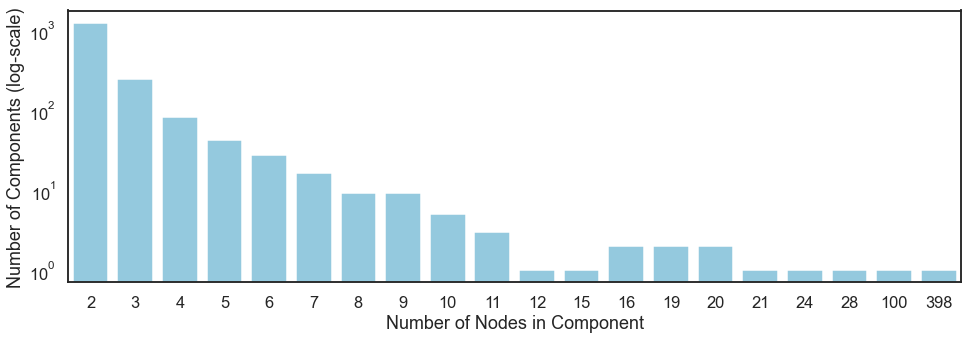

In [4]:
plt.figure(figsize=(16,5))
component_sizes = pd.Series([len(c) for c in components]).value_counts().reset_index()
component_sizes.columns = ['Number of Nodes', 'Number of Components']
sns.set_theme(style="white", context="talk")
chart = sns.barplot(data=component_sizes, y="Number of Components", x="Number of Nodes", color='skyblue')
chart.set_yscale("log")
_ = chart.set(xlabel="Number of Nodes in Component", ylabel="Number of Components (log-scale)")

In [5]:
# Take largest component
g_giant = g.clusters("weak").giant()
print(f"Largest component summary: {ig.summary(g_giant)}")

print(f"Probability of edge forming: {555 / (398 * 397 / 2)}")

# Export edges and vertices of giant component
g_giant.get_edge_dataframe().to_csv('g_giant_edges.csv')
g_giant.get_vertex_dataframe().to_csv('g_giant_vertices.csv')

IGRAPH UN-- 398 555 -- 
+ attr: name (v), order_id (e), timestamp (e)
Largest component summary: None
Probability of edge forming: 0.0070250496816576585


In [9]:
# Form dataframe of all existing and missing edges
def get_all_edges(g):
    edges = pd.DataFrame(list(combinations(g.vs.indices, 2)), columns=['A', 'B'])
    return edges

# 1 if there is edge
def find_edge(A_col, B_col, g):
    results = []
    for i,j in zip(A_col, B_col):
        A, B = int(i), int(j)
        try:
            g.es.find(_between=((A,), (B,)))
            results.append(1)
        except ValueError:
            results.append(0)
    return results

# Assign Product ID back into edge lists
def get_product_ids(edges, g):
    edges['A Product ID'] = edges['A'].apply(lambda i: g.vs['name'][i])
    edges['B Product ID'] = edges['B'].apply(lambda i: g.vs['name'][i])
    return edges


def get_edge_id(A_col, B_col, g):
    results = []
    for i,j in zip(A_col, B_col):
        A, B = int(i), int(j)
        try:
            id = g.get_eid(A, B)
            results.append(id)
        except:
            results.append(np.nan)
    return results

# Compute shortest path of two vertices (this computation excludes existing edge between the two)

def get_shortest_path(g, A_vertices, B_vertices, edgeIDs, edge_or_not):
    negated_shortest_paths = []
    for A, B, edgeID, edge in zip(A_vertices, B_vertices, edgeIDs, edge_or_not):
        A, B = int(A), int(B)
        if edge == 1:
            g_temp = g.copy()
            g_temp.delete_edges(int(edgeID))
            sp = g_temp.shortest_paths(A, B)
            del g_temp
        elif edge == 0:
            sp = g.shortest_paths(A, B)
        negated_shortest_paths.append(-sp[0][0])
    return negated_shortest_paths

# Measure extent of common neighbours through Jaccard similarity
def get_jaccard_similarity(g, A_vertices, B_vertices, edgeIDs, edge_or_not):
    jss = []
    for A, B, edgeID, edge in zip(A_vertices, B_vertices, edgeIDs, edge_or_not):
        A, B = int(A), int(B)
        if edge == 1:
            g_temp = g.copy()
            g_temp.delete_edges(int(edgeID))
            js = g_temp.similarity_jaccard(pairs=[(A, B)])
            del g_temp
        elif edge == 0:
            js = g_giant.similarity_jaccard(pairs=[(A, B)])
        jss.append(js[0])
    return jss

In [10]:
def process_edges(g):

    edges = get_all_edges(g)
    
    edges["Edge"] = find_edge(edges["A"], edges["B"], g)
    
    edges = get_product_ids(edges, g)


    edges["Edge ID"] = get_edge_id(edges["A"], edges["B"], g)

    edges["Negated Shortest Path"] = get_shortest_path(g, edges["A"], edges["B"], edges["Edge ID"], edges["Edge"])

    # Replace negative infinity with the minimum negated shortest path
    edges["Negated Shortest Path"] = (
        edges["Negated Shortest Path"]
        .replace(-np.inf, edges[edges["Negated Shortest Path"]!=-np.inf]["Negated Shortest Path"].min())
    )

    edges["Common Neighbours Jaccard Similarity"] = get_jaccard_similarity(g, edges["A"], edges["B"], edges["Edge ID"], edges["Edge"])
    

    # Calculate how "rich" two vertices are by their product of degrees
    edges["Preferential Attachment"] = edges.apply(lambda row: g.degree(int(row["A"])) * g.degree(int(row["B"])), axis=1)

    # Add on standard network metrics
    for func in [
        g.degree,
        g.closeness,
        g.betweenness,
        g.pagerank,
        g.transitivity_local_undirected
    ]:
        for c in ["A", "B"]:
            edges[f"{c}_{func.__name__}"] = func(edges[c])

    # Merge edges to get timestamp to do train test split by time
    edges = edges.merge(
        g.get_edge_dataframe(),
        left_on = ['A', 'B'],
        right_on = ['source', 'target'],
        how='left'
    )

    return edges

In [12]:
edges = process_edges(g_giant)

In [13]:
edges[edges.Edge==1][[
    'Negated Shortest Path',
    'Common Neighbours Jaccard Similarity', 
    'Preferential Attachment',
    ]].describe()

,Negated Shortest Path,Common Neighbours Jaccard Similarity,Preferential Attachment
count,555.000000,555.000000,555.000000
mean,-13.088288,0.121831,25.427027
std,13.166709,0.150068,35.132852
min,-29.000000,0.000000,2.000000
25%,-29.000000,0.000000,7.000000
50%,-2.000000,0.066667,14.000000
75%,-2.000000,0.222222,28.000000
max,-2.000000,0.666667,322.000000


In [14]:
edges[edges.Edge==0][[
    'Negated Shortest Path',
    'Common Neighbours Jaccard Similarity', 
    'Preferential Attachment',
    ]].describe()

,Negated Shortest Path,Common Neighbours Jaccard Similarity,Preferential Attachment
count,78448.000000,78448.000000,78448.000000
mean,-10.192828,0.003334,7.636154
std,4.759555,0.025759,11.751733
min,-29.000000,0.000000,1.000000
25%,-13.000000,0.000000,2.000000
50%,-10.000000,0.000000,4.000000
75%,-6.000000,0.000000,8.000000
max,-2.000000,0.500000,368.000000


In [15]:
# Define features
features = [
    'Negated Shortest Path',
    'Common Neighbours Jaccard Similarity', 
    'Preferential Attachment',
    # 'Adamic Adar',
    'A_degree',
    'B_degree',
    'A_closeness',
    'B_closeness',
    'A_betweenness',
    'B_betweenness',
    'A_pagerank',
    'B_pagerank',
    'A_transitivity_local_undirected',
    'B_transitivity_local_undirected'
    ]

<AxesSubplot:>

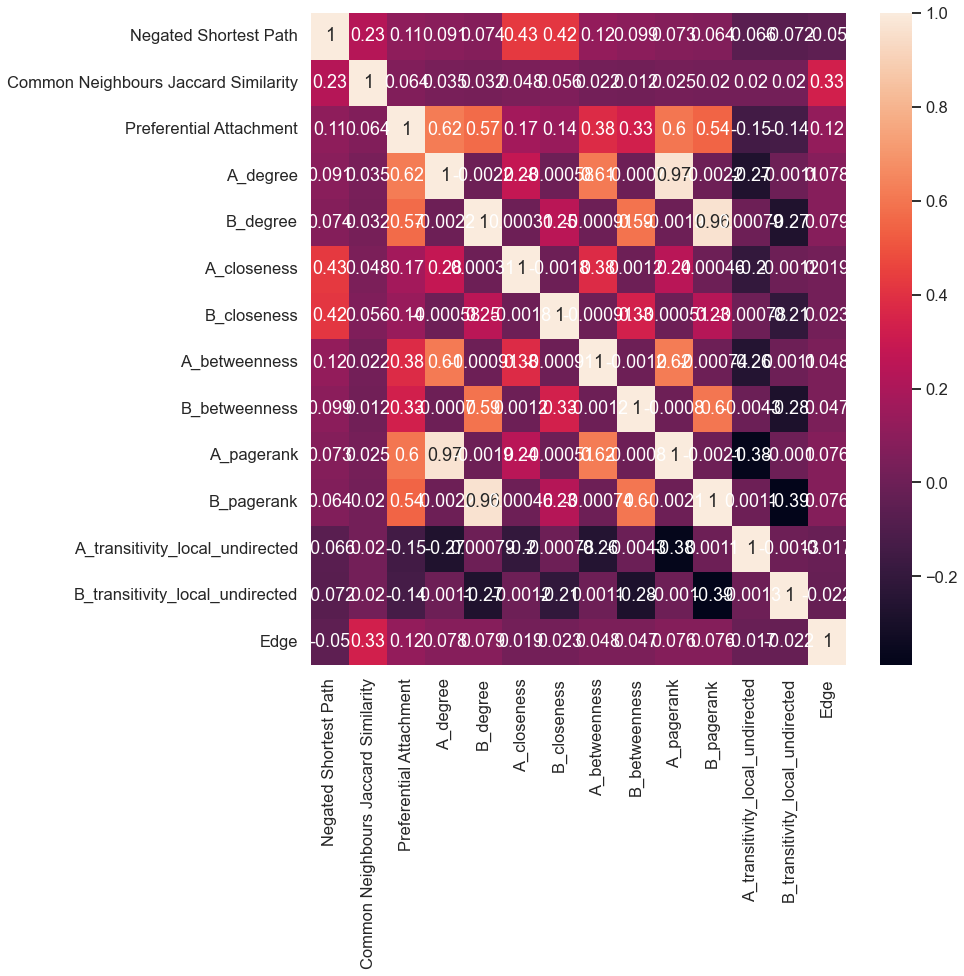

In [16]:
plt.figure(figsize=(12,12))

sns.heatmap(edges[[*features, 'Edge']].corr(), annot=True)

# Modelling

## Define Modelling Functions

In [17]:
def train_test_split_by_time(df, train_size=0.75, features=features):
    '''
    Applies a ratio to split actual edges by time and randomly assign missing edges to train or test. 
    '''
    # Fill missing features with 0
    df[features] = df[features].fillna(0)

    actual_edges = df[df.timestamp.notnull()]
    missing_edges = df[df.timestamp.isnull()]

    # Determine cutoff date
    edge_count_in_train = round(g_giant.ecount() * train_size)
    cutoff = actual_edges.timestamp.sort_values().iloc[edge_count_in_train]

    # Split missing edges according to ratio
    missing_edges_train = missing_edges.sample(round(3/4 * len(missing_edges)), random_state = 0)
    missing_edges_test = missing_edges[~missing_edges.index.isin(missing_edges_train.index)]

    # Combine train and test
    train = pd.concat([
        actual_edges[actual_edges.timestamp <= cutoff],
        missing_edges_train
    ])

    test = pd.concat([
        actual_edges[actual_edges.timestamp > cutoff],
        missing_edges_test
    ])

    # Split X and Y
    X_train, y_train = train[features], train["Edge"]
    X_test, y_test = test[features], test["Edge"]

    return X_train, y_train, X_test, y_test

In [18]:
def get_feature_importances(model_step):
    feature_importances = pd.DataFrame({
        'Feature Names': features,
        'Importance': model_step.feature_importances_
    })
    return feature_importances.sort_values('Importance', ascending=False)

In [19]:
# Split train test by time
X_train, y_train, X_test, y_test = train_test_split_by_time(edges)

In [20]:
# Export train test split for other team mates' experimentation
# xls = pd.ExcelWriter('./data/train_test_split.xlsx')
# edges.to_excel(xls, sheet_name='edges')
# X_train.to_excel(xls, sheet_name='X_train')
# X_test.to_excel(xls, sheet_name='X_test')
# y_train.to_excel(xls, sheet_name='y_train')
# y_test.to_excel(xls, sheet_name='y_test')
# xls.close()

In [21]:
def run_model(pipe, params, X_train, y_train, X_test, y_test):
    # Perform grid search CV over parameters
    grid = GridSearchCV(pipe, params, scoring="f1_macro")
    grid.fit(X_train, y_train)

    # Print best parameters and score
    print("Grid best params: ", grid.best_params_)
    print("Grid best score: ", grid.best_score_)

    # Print other metrics
    y_pred = grid.predict(X_test)
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred), '\n')
    print("AUC: ", roc_auc_score(y_test, y_pred))
    print("Recall: ", recall_score(y_test, y_pred))
    print("Precision: ", precision_score(y_test, y_pred))
    print("F1 score: ", f1_score(y_test, y_pred))

    return grid

## Modelling All Potential Links

### Logistic Regression

In [22]:
oversampler = SMOTE(random_state=0)
lr = LogisticRegression(random_state=0, max_iter=1000)
pipe = make_pipeline(MinMaxScaler(), oversampler, lr)

param_grid = {
    'logisticregression__C': [100, 10, 1.0, 0.1, 0.01]
}

grid = run_model(pipe, param_grid, X_train, y_train, X_test, y_test)

# Save grid
grid_lr = grid

Grid best params:  {'logisticregression__C': 100}
Grid best score:  0.6218928195640232
Confusion matrix: 
 [[18886   726]
 [   10   128]] 

AUC:  0.9452590398661571
Recall:  0.927536231884058
Precision:  0.14988290398126464
F1 score:  0.25806451612903225


### Decision Tree

In [23]:
oversampler = SMOTE(random_state=0)
dt = DecisionTreeClassifier(random_state=0)
pipe = make_pipeline(MinMaxScaler(), oversampler, dt)

param_grid = {
    'decisiontreeclassifier__max_depth': [2, 3, 4, 5],
    'decisiontreeclassifier__ccp_alpha': [0.01, 0.02, 0.03, 0.04, 0.05],
    'decisiontreeclassifier__min_samples_split': [2, 3, 4, 5]
}

grid = run_model(pipe, param_grid, X_train, y_train, X_test, y_test)

# Save grid
grid_dt = grid

Grid best params:  {'decisiontreeclassifier__ccp_alpha': 0.01, 'decisiontreeclassifier__max_depth': 2, 'decisiontreeclassifier__min_samples_split': 2}
Grid best score:  0.6847203949788003
Confusion matrix: 
 [[19195   417]
 [    9   129]] 

AUC:  0.9567600581720154
Recall:  0.9347826086956522
Precision:  0.23626373626373626
F1 score:  0.37719298245614036


### Random Forest

In [25]:
# Try random forest
oversampler = SMOTE(random_state=0)
rf = RandomForestClassifier(random_state=0, n_estimators=10)
pipe = make_pipeline(MinMaxScaler(), oversampler, rf)

param_grid = {
    'randomforestclassifier__max_depth': [2, 3, 4, 5],
    'randomforestclassifier__ccp_alpha': [0.01, 0.02, 0.03, 0.04, 0.05],
    'randomforestclassifier__min_samples_split': [2, 3, 4, 5]
}

grid = run_model(pipe, param_grid, X_train, y_train, X_test, y_test)

# Save grid
grid_rf = grid

Grid best params:  {'randomforestclassifier__ccp_alpha': 0.04, 'randomforestclassifier__max_depth': 4, 'randomforestclassifier__min_samples_split': 2}
Grid best score:  0.7080732050643304
Confusion matrix: 
 [[18425  1187]
 [   10   128]] 

AUC:  0.9335060315039299
Recall:  0.927536231884058
Precision:  0.09733840304182509
F1 score:  0.17618719889883


### XGBoost

In [26]:
# Try XGBoost
oversampler = SMOTE(random_state=0)
xgb_clf = xgb.XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='mlogloss')
pipe = make_pipeline(MinMaxScaler(), oversampler, xgb_clf)

param_grid = {
     "xgbclassifier__max_depth"        : [ 3, 4, 10],
     "xgbclassifier__min_child_weight" : [ 1, 3 ]
}

grid = run_model(pipe, param_grid, X_train, y_train, X_test, y_test)

# Save grid
grid_xgb_clf = grid

Grid best params:  {'xgbclassifier__max_depth': 10, 'xgbclassifier__min_child_weight': 1}
Grid best score:  0.9151908162062762
Confusion matrix: 
 [[19588    24]
 [   25   113]] 

AUC:  0.9088084195715725
Recall:  0.8188405797101449
Precision:  0.8248175182481752
F1 score:  0.8218181818181818


In [27]:
get_feature_importances(grid.best_estimator_.named_steps["xgbclassifier"])

,Feature Names,Importance
0,Negated Shortest Path,0.619565
1,Common Neighbours Jaccard Similarity,0.269652
12,B_transitivity_local_undirected,0.030762
11,A_transitivity_local_undirected,0.018515
3,A_degree,0.013399
4,B_degree,0.011649
8,B_betweenness,0.011613
7,A_betweenness,0.006861
10,B_pagerank,0.005461
2,Preferential Attachment,0.003937


# Predicting on Other Components

In [28]:
def print_scores(truth, y_pred, prints=True):
    if prints:
        print('Confusion matrix: \n', confusion_matrix(truth, y_pred), '\n')
        print("AUC: ", roc_auc_score(truth, y_pred))
        print("Recall: ", recall_score(truth, y_pred))
        print("Precision: ", precision_score(truth, y_pred))
        print("F1 score: ", f1_score(truth, y_pred))

    return f1_score(truth, y_pred), recall_score(truth, y_pred), precision_score(truth, y_pred)

df = pd.DataFrame({
    'Node Size': [g.vcount() for g in g.decompose("weak")]
})
component_order = df.sort_values('Node Size', ascending=False).index.tolist()
df.sort_values('Node Size', ascending=False).head(20)

,Node Size
45,398
19,100
508,28
62,24
214,21
173,20
22,20
24,19
221,19
171,16


In [29]:
def score_on_other_components(component_graph_no, prints=True):
    # Apply on other components
    g_other = [g for g in g.decompose("weak")][component_graph_no]
    if prints:
        print(ig.summary(g_other))

    edges_other = process_edges(g_other)

    # Fill missing features with 0
    edges_other[features] = edges_other[features].fillna(0)

    f1, recall, precision = print_scores(edges_other["Edge"], grid_xgb_clf.best_estimator_.predict(edges_other[features]), prints)

    return f1, recall, precision

score_on_other_components(19)

IGRAPH UN-- 100 153 -- 
+ attr: name (v), order_id (e), timestamp (e)
None
Confusion matrix: 
 [[4775   22]
 [  74   79]] 

AUC:  0.7558768347864474
Recall:  0.5163398692810458
Precision:  0.7821782178217822
F1 score:  0.6220472440944882


(0.6220472440944882, 0.5163398692810458, 0.7821782178217822)

In [30]:
score_on_other_components(508)

IGRAPH UN-- 28 49 -- 
+ attr: name (v), order_id (e), timestamp (e)
None
Confusion matrix: 
 [[326   3]
 [ 12  37]] 

AUC:  0.8729917498914459
Recall:  0.7551020408163265
Precision:  0.925
F1 score:  0.8314606741573034


(0.8314606741573034, 0.7551020408163265, 0.925)

In [31]:
score_on_other_components(62)

IGRAPH UN-- 24 31 -- 
+ attr: name (v), order_id (e), timestamp (e)
None
Confusion matrix: 
 [[243   2]
 [ 14  17]] 

AUC:  0.7701119157340356
Recall:  0.5483870967741935
Precision:  0.8947368421052632
F1 score:  0.6799999999999999


(0.6799999999999999, 0.5483870967741935, 0.8947368421052632)